In [1]:
%load_ext autoreload


In [2]:
import os
import numpy as np
from matplotlib import pyplot as plt
import cmasher as cmr
import corner    
import multiprocessing as mpr
mpr.set_start_method('fork')
#import gp_init_threads as th_init
from all_prof_functions import (run_each_gp, plot_recon_profs)

%aimport -os -np -plt -cmr -mpr -corner
%autoreload 2


In [3]:
# Set up some plotting stuff
plt.rc('savefig', bbox='tight')
use_bk_bgd = True #### Change this to use white backgrounds for plots  #####
if use_bk_bgd:
    plot_style = 'dark_background'
    # The CMasher package provides lots of lovely colour maps; chroma is a handy sequential cmap
    cmap = cmr.chroma_r
    c1 = cmap(0.0)
    c2 = cmap(0.1)
    c3 = cmap(0.33)
    c4 = cmap(0.55)
    c5 = cmap(0.68)
    c6 = cmap(0.815)

else:
    plot_style = 'default'
    cmap = cmr.chroma
    c1 = cmap(0.0)
    c2 = cmap(0.3)
    c3 = cmap(0.53)
    c4 = cmap(0.65)
    c5 = cmap(0.78)
    c6 = cmap(0.915)


The following cell contains variables describing the dataset and where the data are located. Change them as needed. 

In [4]:
data_dir = '/home/s86932rs/research/nudot_stuff/'
plots_dir = os.path.join(data_dir, 'plots')
psr = 'J2043+2740'
freq = 1400
be = 'afb'


In [5]:
be = be.lower()
BE = be.upper()
npz_file = os.path.join(data_dir, psr+'_{}_eigs.npz'.format(freq))
exist_AFB = True
exist_DFB = True
with np.load(npz_file) as d:
    if 'AFB_errs' in d.keys():
        AFB_errs = d['AFB_errs']
        AFB_mean = d['AFB_mean']
        AFB_eigval = d['AFB_values']
        AFB_eigvec = d['AFB_vectors']
        AFB_eigval_bin = d['AFB_bin_vals']
        AFB_mjds = d['AFB_mjds']
        AFB_mjds_bin = d['AFB_bin_mjds']
        AFB_rms = d['AFB_rms']
    else:
        exist_AFB = False
        
    if 'DFB_errs' in d.keys():
        DFB_errs = d['DFB_errs']
        DFB_mean = d['DFB_mean']
        DFB_eigval = d['DFB_values']
        DFB_eigvec = d['DFB_vectors']
        DFB_eigval_bin = d['DFB_bin_vals']
        DFB_mjds = d['DFB_mjds']
        DFB_mjds_bin = d['DFB_bin_mjds']
        DFB_rms = d['DFB_rms']
    else:
        exist_DFB = False
        
    val_bin_len = d['val_bin_len']
    val_bin_overlap = d['val_bin_lap']

print("Binning was done with a length scale of {}.".format(val_bin_len))
if exist_AFB:
    print("The shape of the AFB eigval array is {}.".format(AFB_eigval.shape))
    if len(AFB_errs) == AFB_eigval.shape[0] and len(AFB_mean) == AFB_eigvec.shape[1] and AFB_eigval.shape[1] == AFB_eigvec.shape[0] \
        and AFB_eigval.shape[0] == len(AFB_mjds) and AFB_eigval.shape[0] == len(AFB_rms) and AFB_eigval_bin.shape[0] == len(AFB_mjds_bin):
        print("All AFB shapes and lengths agree")
    else:
        print("WARNING: Lengths and shapes for AFB do not agree!")
    
if exist_DFB:
    print("The shape of the DFB eigval array is {}.".format(DFB_eigval.shape))
    if len(DFB_errs) == DFB_eigval.shape[0] and len(DFB_mean) == DFB_eigvec.shape[1] and DFB_eigval.shape[1] == DFB_eigvec.shape[0] \
        and DFB_eigval.shape[0] == len(DFB_mjds) and DFB_eigval.shape[0] == len(DFB_rms) and DFB_eigval_bin.shape[0] == len(DFB_mjds_bin):
        print("All DFB shapes and lengths agree")
    else:
        print("WARNING: Lengths and shapes for DFB do not agree!")


Binning was done with a length scale of 200.
The shape of the AFB eigval array is (274, 30).
All AFB shapes and lengths agree
The shape of the DFB eigval array is (376, 30).
All DFB shapes and lengths agree


<Figure size 640x480 with 0 Axes>

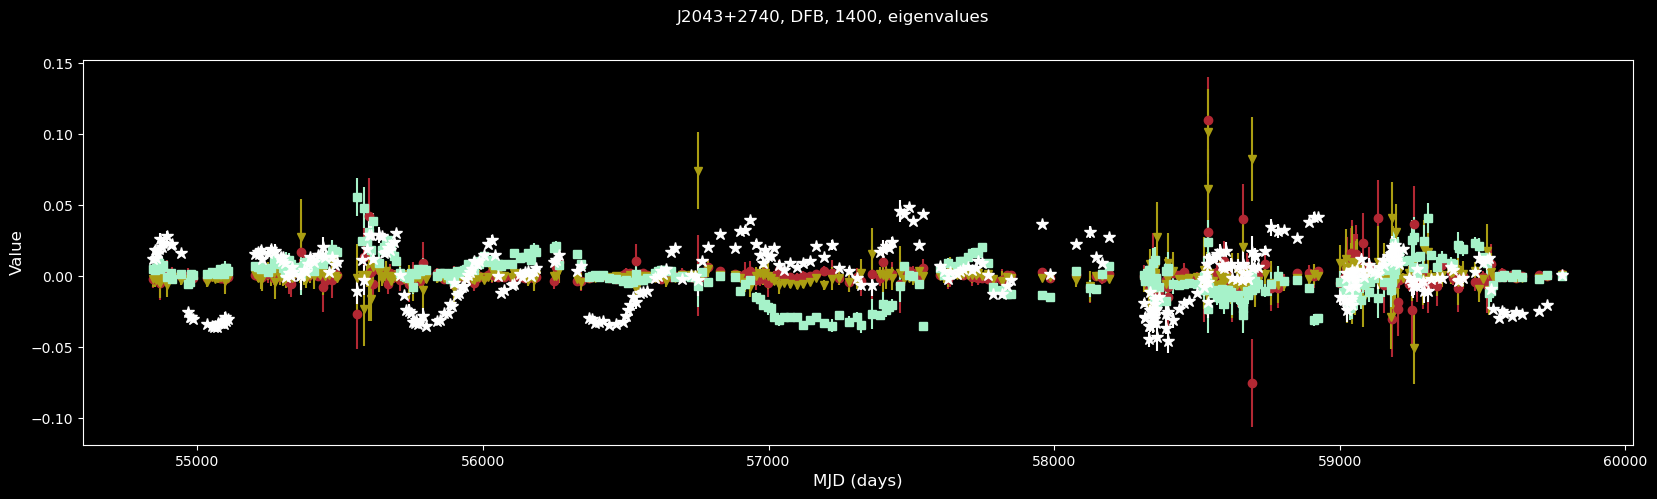

In [6]:
if exist_DFB and True:
    with plt.style.context(plot_style):
        plt.clf()
        fig = plt.figure(figsize=(20, 5))
        fig.suptitle("{}, DFB, {}, eigenvalues".format(psr, freq))
        ax1 = fig.gca()
        ax1.errorbar(DFB_mjds, DFB_eigval[:,3], yerr=DFB_errs[:,3], fmt='o', ecolor=c4, mec=c4, mfc=c4)
        ax1.errorbar(DFB_mjds, DFB_eigval[:,2], yerr=DFB_errs[:,2], fmt='v', ecolor=c3, mec=c3, mfc=c3)
        ax1.errorbar(DFB_mjds, DFB_eigval[:,1], yerr=DFB_errs[:,1], fmt='s', ecolor=c2, mec=c2, mfc=c2)
        ax1.errorbar(DFB_mjds, DFB_eigval[:,0], yerr=DFB_errs[:,0], fmt='*', ecolor=c1, mec=c1, mfc=c1, ms=9)
        ax1.set_xlabel('MJD (days)', fontsize=12)
        ax1.set_ylabel('Value', fontsize=12)


In [7]:
if exist_DFB:
    print(DFB_mjds[DFB_eigval[:,0] == min(DFB_eigval[:,0])])


[58397.05353]


In [8]:
if exist_DFB:
    _, bins, _ = plt.hist(DFB_mjds[1:] - DFB_mjds[:-1], bins=50, label='DFB')
    
if exist_AFB:
    _, _, _ = plt.hist(AFB_mjds[1:] - AFB_mjds[:-1], bins=bins, alpha=0.7, label='AFB')
    
if exist_AFB or exist_DFB:
    plt.xlabel("Separation between observations (MJD)")
    plt.legend()


Running GP for DFB data
The minimum length scale for DFB is 57.61
Subtracting 54845 from MJDs (will return true MJD values)
The initial parameter vector is [ 0.00000000e+00  6.20132379e+00 -3.94277926e+00  3.02653883e-18]
Running burn-in


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 75.34it/s]


Running second burn-in


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 85.76it/s]


Running production chain


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:11<00:00, 70.33it/s]


The array of autocorrelation times is [47.36505255 52.5532396  55.99205183 45.53355637]


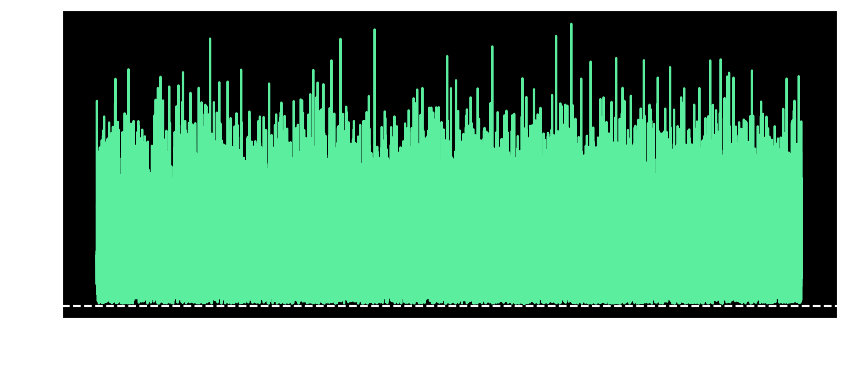

The bounds returned by the attribute are [(-15, 15), (4.053621246253011, 7.810761705902729), (-15, 15), (None, None)]
The 2nd lower bound was breached, reaching a min. of -29.99


<Figure size 640x480 with 0 Axes>

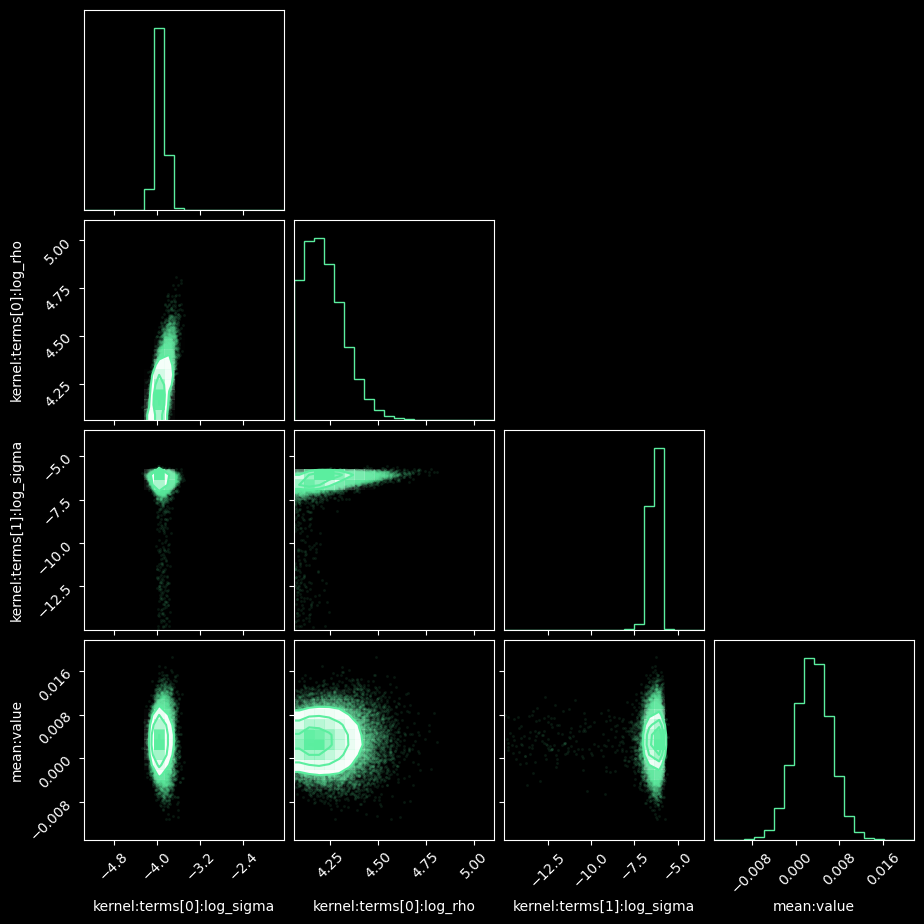

The initial parameter vector is [ 0.00000000e+00  6.20132379e+00 -4.30202464e+00  2.95272081e-18]
Running burn-in


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:04<00:00, 67.65it/s]


Running second burn-in


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:04<00:00, 65.14it/s]


Running production chain


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:14<00:00, 66.99it/s]


The array of autocorrelation times is [50.39933491 53.35606575 64.99416838 50.11616184]


<Figure size 640x480 with 0 Axes>

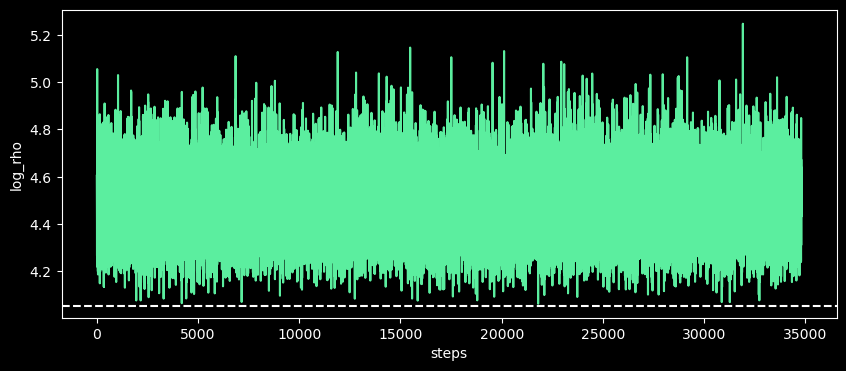

The bounds returned by the attribute are [(-15, 15), (4.053621246253011, 7.810761705902729), (-15, 15), (None, None)]
The 2nd lower bound was breached, reaching a min. of -30.00


<Figure size 640x480 with 0 Axes>

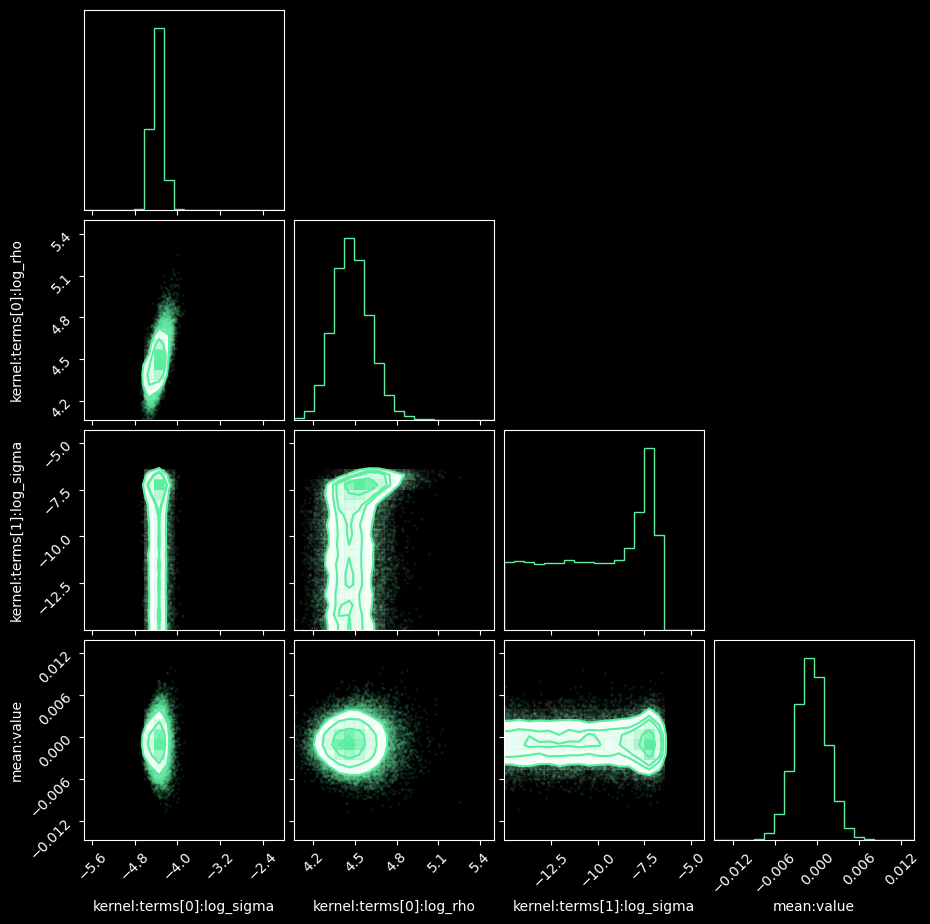

The initial parameter vector is [ 0.00000000e+00  6.20132379e+00 -4.53919253e+00 -2.28835863e-18]
Running burn-in


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:04<00:00, 64.45it/s]


Running second burn-in


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:04<00:00, 64.46it/s]


Running production chain


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:14<00:00, 67.02it/s]


The array of autocorrelation times is [70.39757418 56.63736898 59.74231856 52.16411145]


<Figure size 640x480 with 0 Axes>

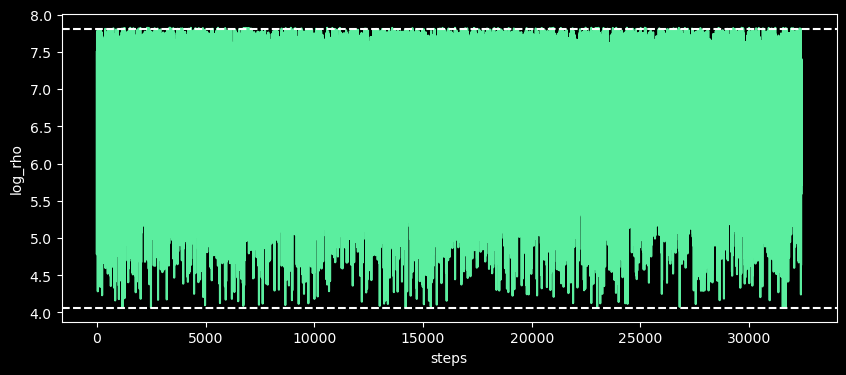

The bounds returned by the attribute are [(-15, 15), (4.053621246253011, 7.810761705902729), (-15, 15), (None, None)]
The 0th lower bound was breached, reaching a min. of -29.91
The 2nd lower bound was breached, reaching a min. of -30.00


<Figure size 640x480 with 0 Axes>

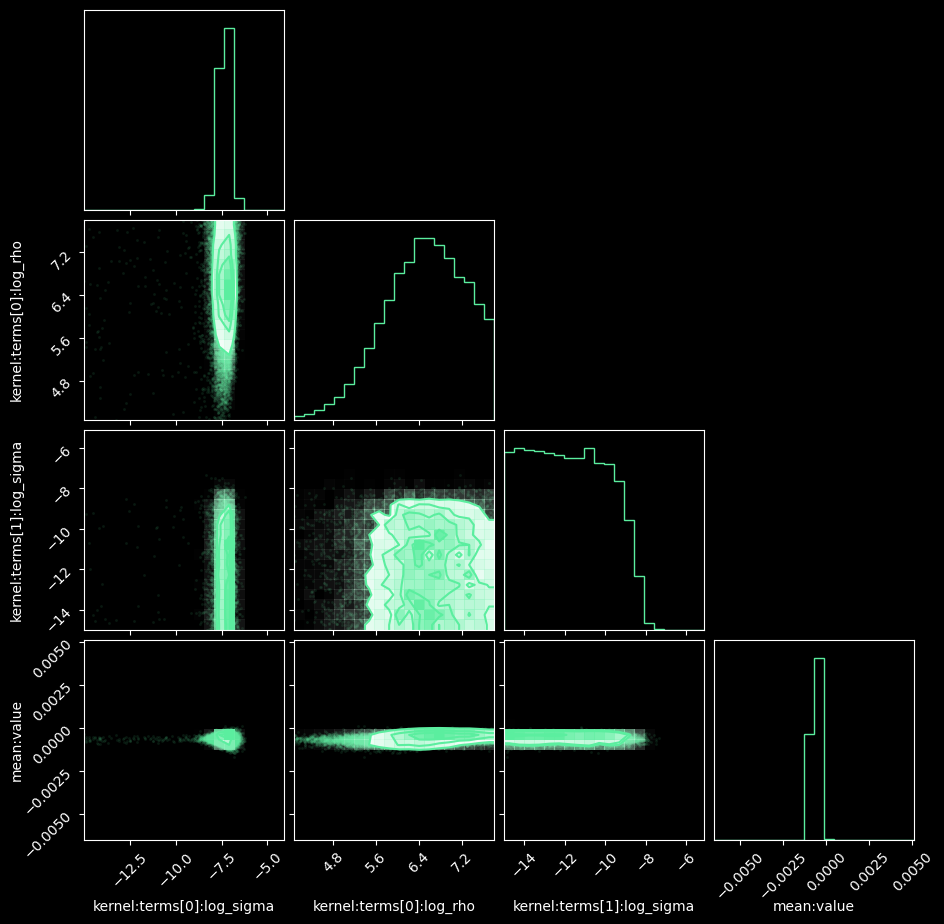

The initial parameter vector is [ 0.00000000e+00  6.20132379e+00 -4.62895743e+00 -9.78088768e-19]
Running burn-in


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:04<00:00, 68.67it/s]


Running second burn-in


  0%|                                                                                                                                                                                      | 0/300 [00:00<?, ?it/s]/home/s86932rs/anaconda3/envs/std/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:04<00:00, 66.88it/s]


Running production chain


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:07<00:00, 73.70it/s]


The array of autocorrelation times is [89.7987922  86.20484253 76.02400769 65.419508  ]


<Figure size 640x480 with 0 Axes>

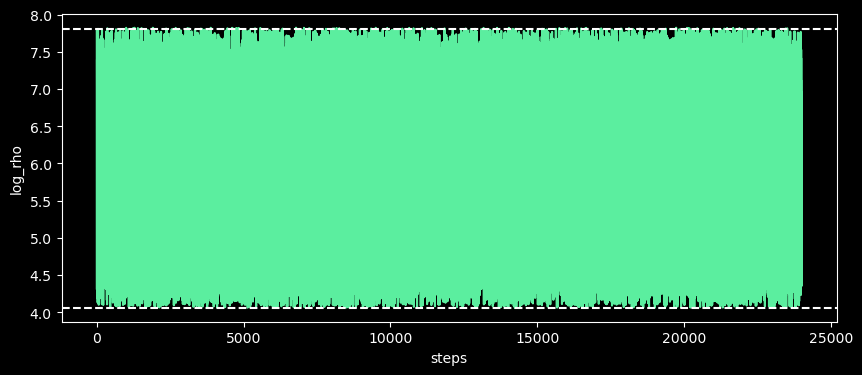

The bounds returned by the attribute are [(-15, 15), (4.053621246253011, 7.810761705902729), (-15, 15), (None, None)]
The 0th lower bound was breached, reaching a min. of -30.00
The 2nd lower bound was breached, reaching a min. of -30.00


<Figure size 640x480 with 0 Axes>

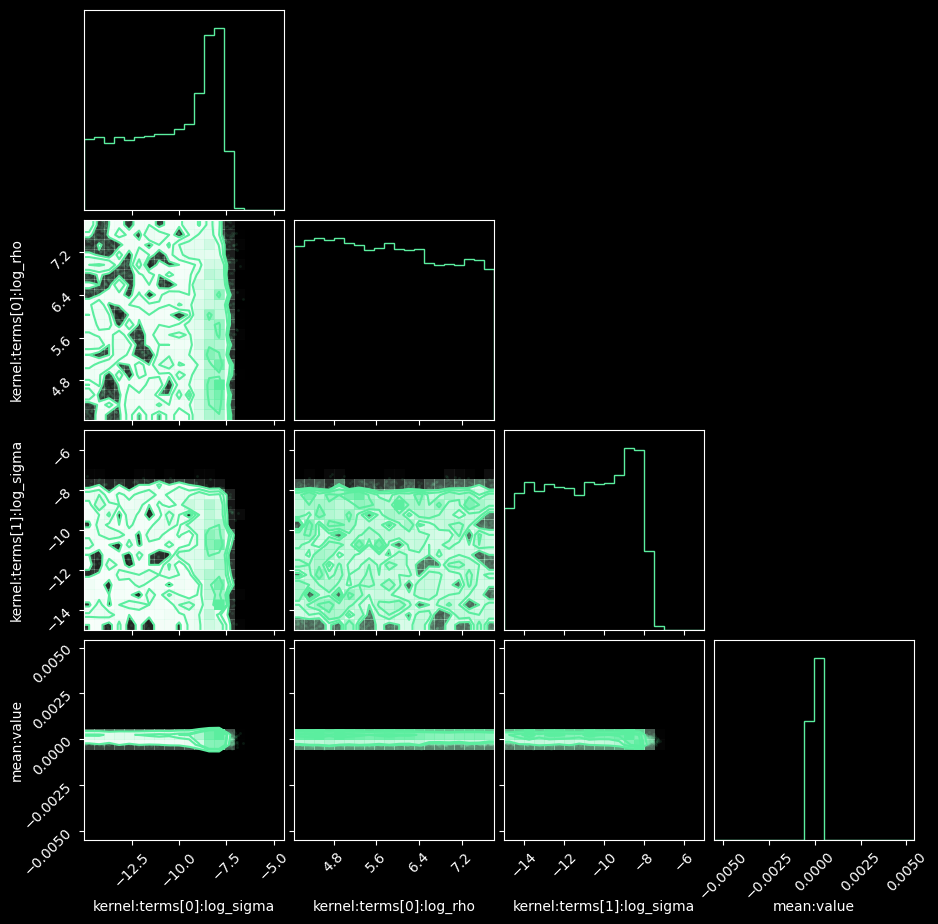

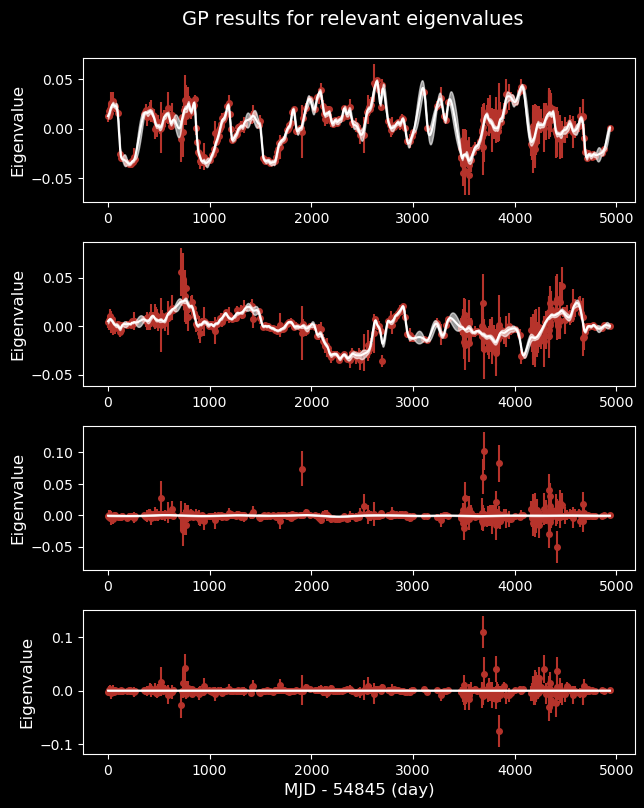

Running GP for AFB data
The minimum length scale for AFB is 82.22
Subtracting 50255 from MJDs (will return true MJD values)
The initial parameter vector is [ 0.00000000e+00  6.23057872e+00 -3.40830641e+00  1.49920627e-17]
Running burn-in


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:04<00:00, 62.83it/s]


Running second burn-in


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:04<00:00, 61.27it/s]


Running production chain


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:21<00:00, 61.62it/s]


The array of autocorrelation times is [44.28851425 45.4314564  42.81079203 43.82683854]


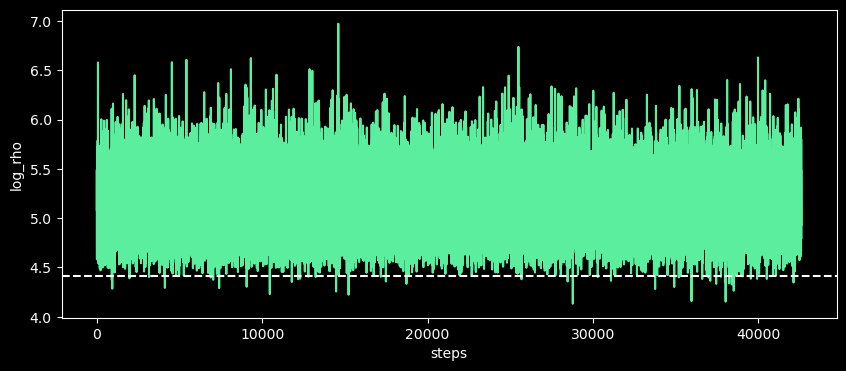

The bounds returned by the attribute are [(-15, 15), (4.409414878588178, 7.8400166343364), (-15, 15), (None, None)]
The 1st lower bound was breached, reaching a min. of 4.13


<Figure size 640x480 with 0 Axes>

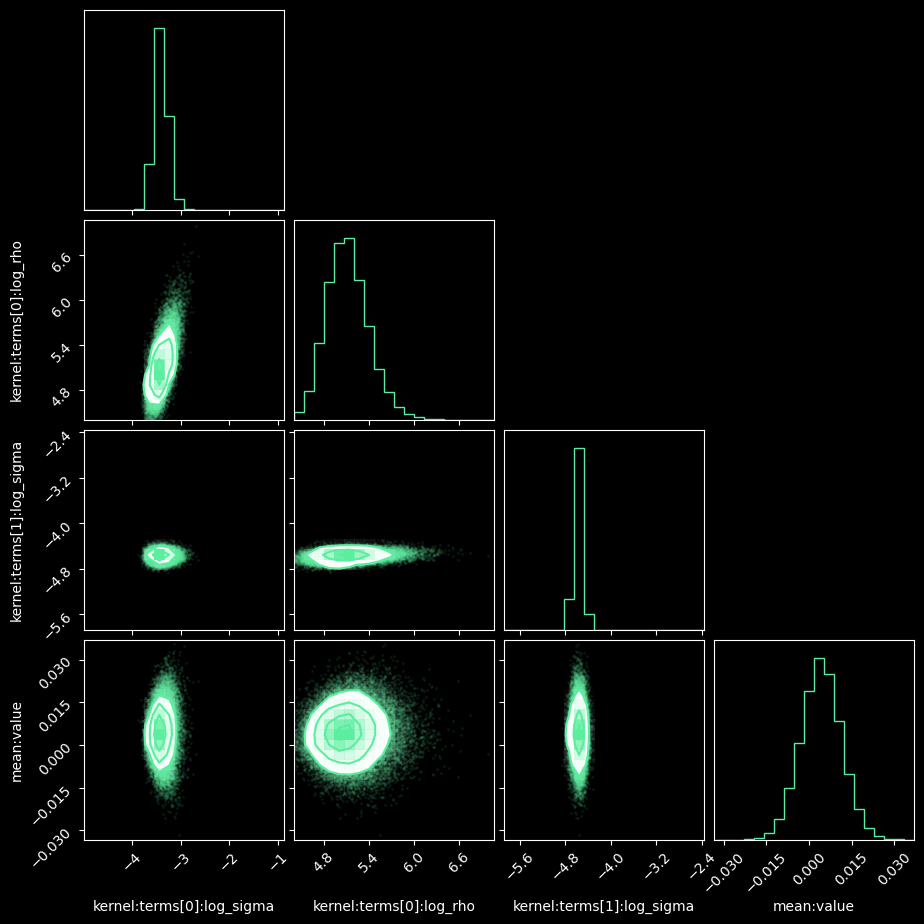

The initial parameter vector is [ 0.00000000e+00  6.23057872e+00 -3.88603614e+00  8.50900858e-18]
Running burn-in


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:04<00:00, 68.53it/s]


Running second burn-in


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:04<00:00, 66.31it/s]


Running production chain


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:14<00:00, 67.32it/s]


The array of autocorrelation times is [52.36749141 72.2667096  57.87531166 50.88670138]


<Figure size 640x480 with 0 Axes>

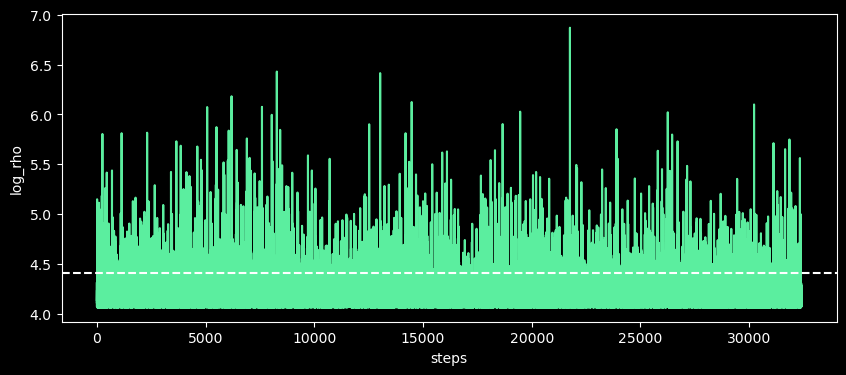

The bounds returned by the attribute are [(-15, 15), (4.409414878588178, 7.8400166343364), (-15, 15), (None, None)]
The 1st lower bound was breached, reaching a min. of 4.06


<Figure size 640x480 with 0 Axes>

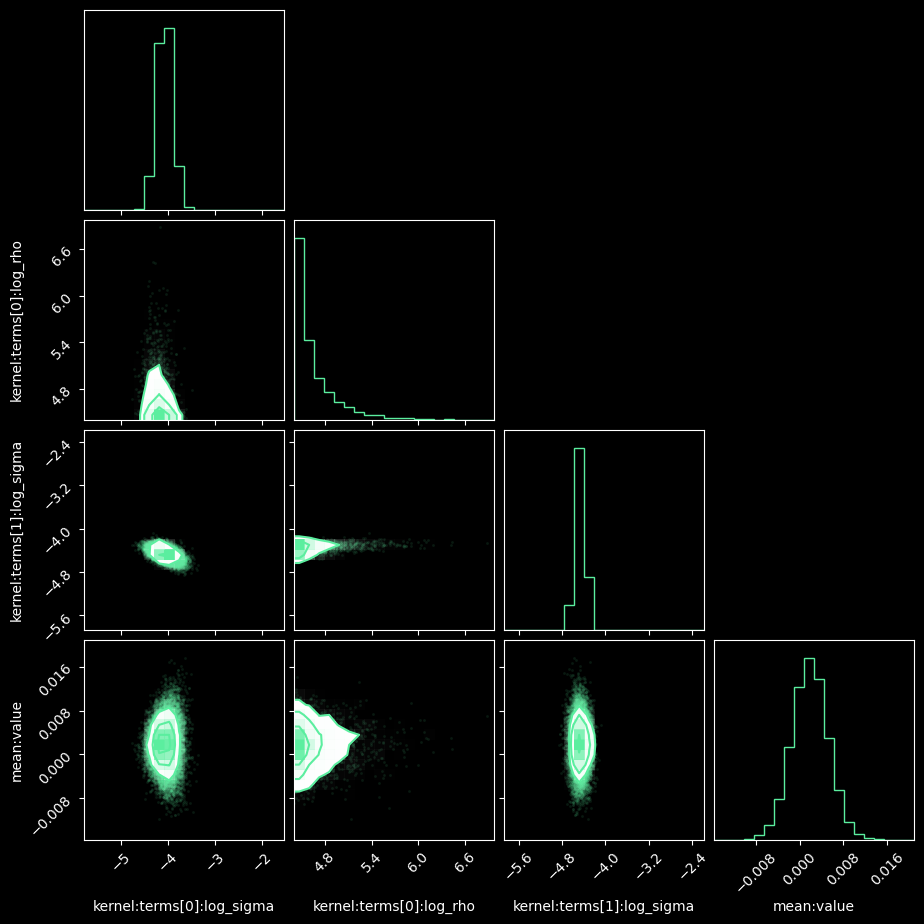

The initial parameter vector is [ 0.00000000e+00  6.23057872e+00 -4.07305561e+00  1.41816810e-18]
Running burn-in


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:04<00:00, 66.81it/s]


Running second burn-in


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:04<00:00, 66.44it/s]


Running production chain


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:14<00:00, 66.67it/s]
N/50 = 100;
tau: [ 54.97584033  80.6699482  213.18822855  54.02579483]


The array of autocorrelation times is [ 54.97584033  80.6699482  213.18822855  54.02579483]


<Figure size 640x480 with 0 Axes>

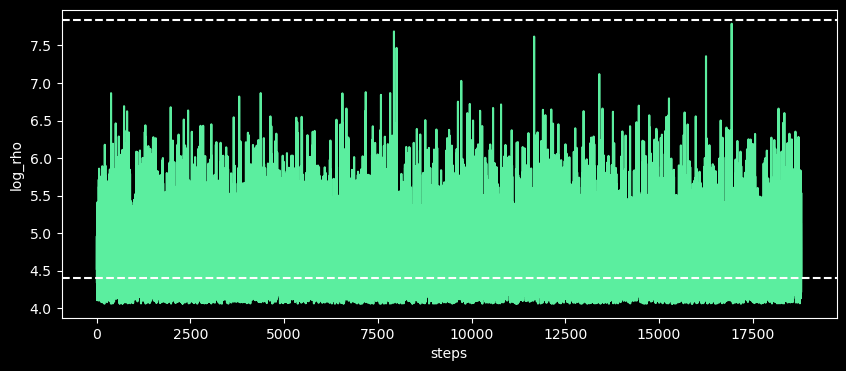

The bounds returned by the attribute are [(-15, 15), (4.409414878588178, 7.8400166343364), (-15, 15), (None, None)]
The 1st lower bound was breached, reaching a min. of 4.06
The 2nd lower bound was breached, reaching a min. of -29.99


<Figure size 640x480 with 0 Axes>

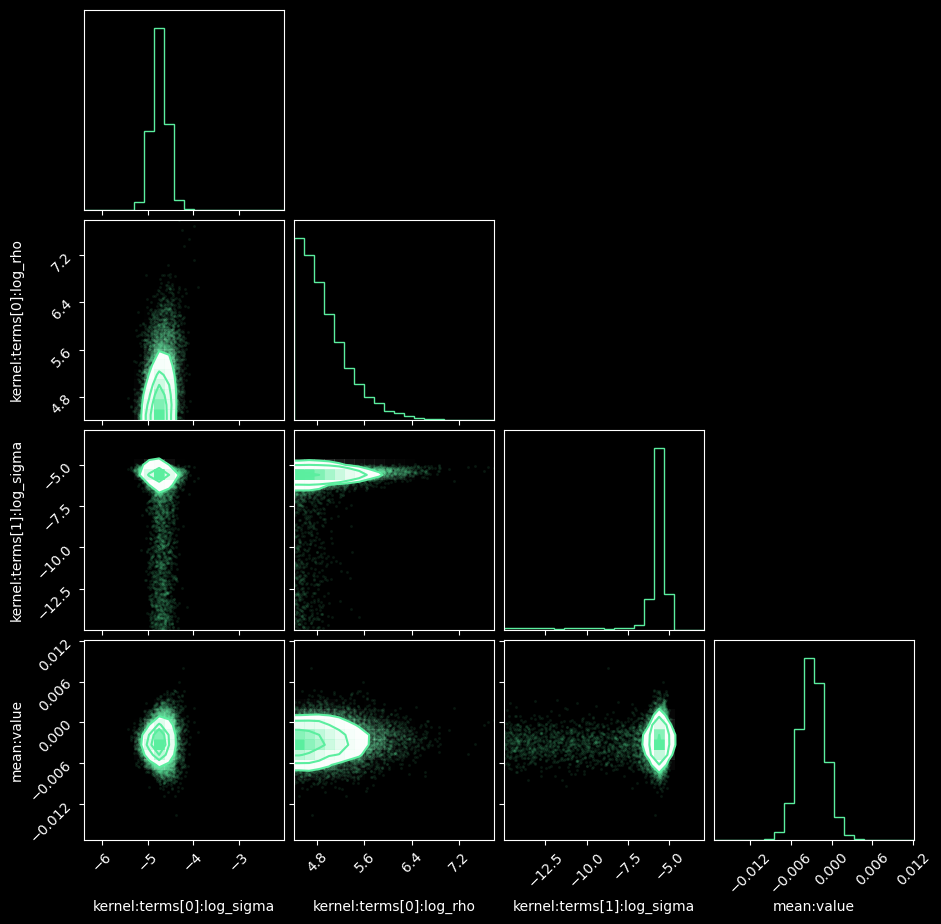

The initial parameter vector is [ 0.00000000e+00  6.23057872e+00 -4.15338715e+00 -2.07660329e-18]
Running burn-in


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:04<00:00, 72.39it/s]


Running second burn-in


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:04<00:00, 68.23it/s]


Running production chain


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:06<00:00, 75.20it/s]
N/50 = 100;
tau: [182.53664851 162.39761078 258.82764379  96.84502332]


The array of autocorrelation times is [182.53664851 162.39761078 258.82764379  96.84502332]


<Figure size 640x480 with 0 Axes>

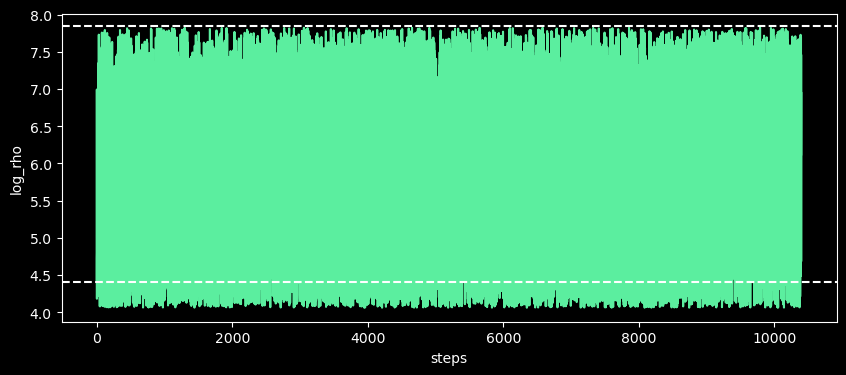

The bounds returned by the attribute are [(-15, 15), (4.409414878588178, 7.8400166343364), (-15, 15), (None, None)]
The 0th lower bound was breached, reaching a min. of -30.00
The 1st lower bound was breached, reaching a min. of 4.06
The 2nd lower bound was breached, reaching a min. of -29.93


<Figure size 640x480 with 0 Axes>

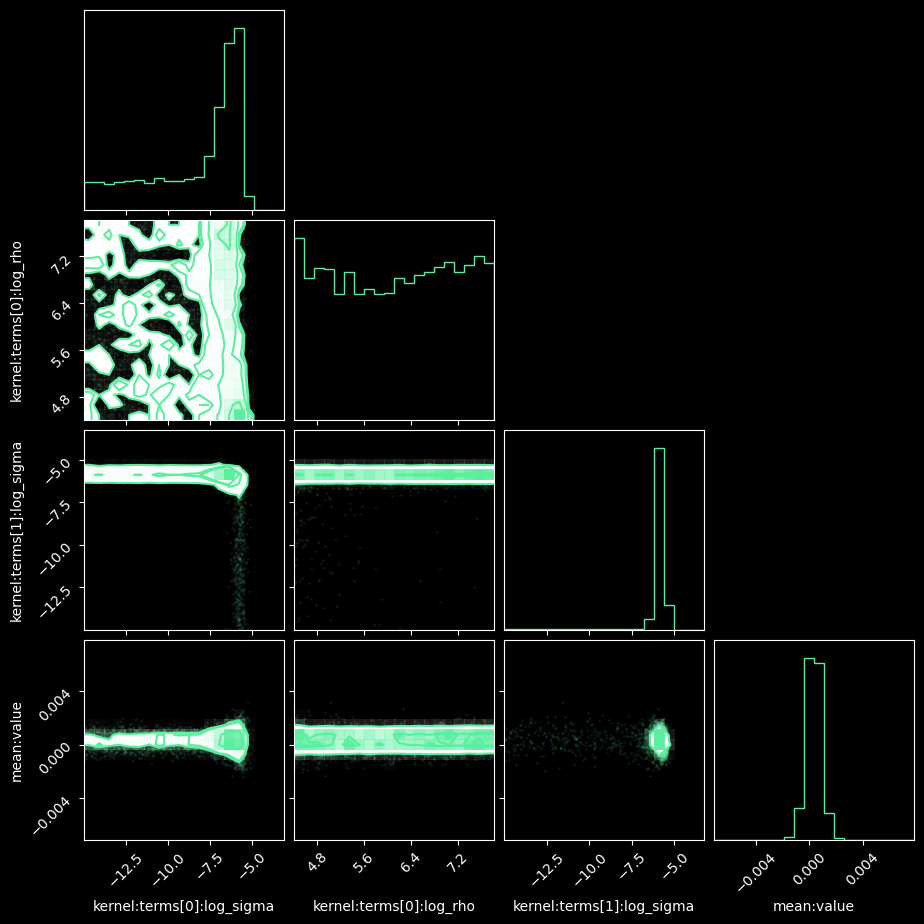

The initial parameter vector is [ 0.00000000e+00  6.23057872e+00 -4.25880598e+00 -4.40645087e-18]
Running burn-in


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:04<00:00, 70.57it/s]


Running second burn-in


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:04<00:00, 67.64it/s]


Running production chain


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:07<00:00, 73.63it/s]


The array of autocorrelation times is [79.45059559 81.97542602 80.17973011 73.57978069]


<Figure size 640x480 with 0 Axes>

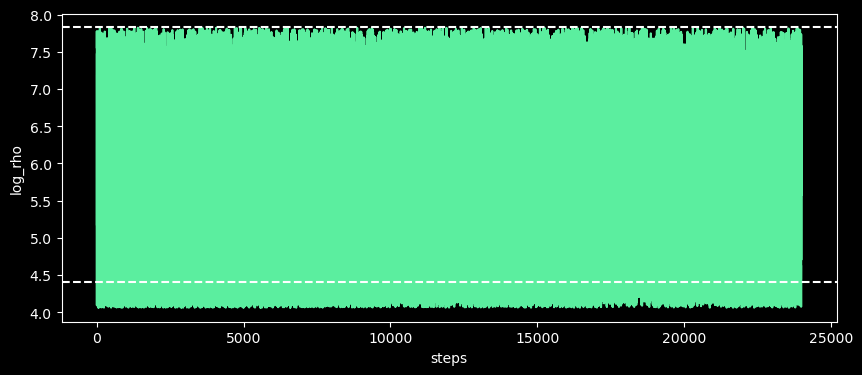

The bounds returned by the attribute are [(-15, 15), (4.409414878588178, 7.8400166343364), (-15, 15), (None, None)]
The 0th lower bound was breached, reaching a min. of -30.00
The 1st lower bound was breached, reaching a min. of 4.06
The 2nd lower bound was breached, reaching a min. of -29.97


<Figure size 640x480 with 0 Axes>

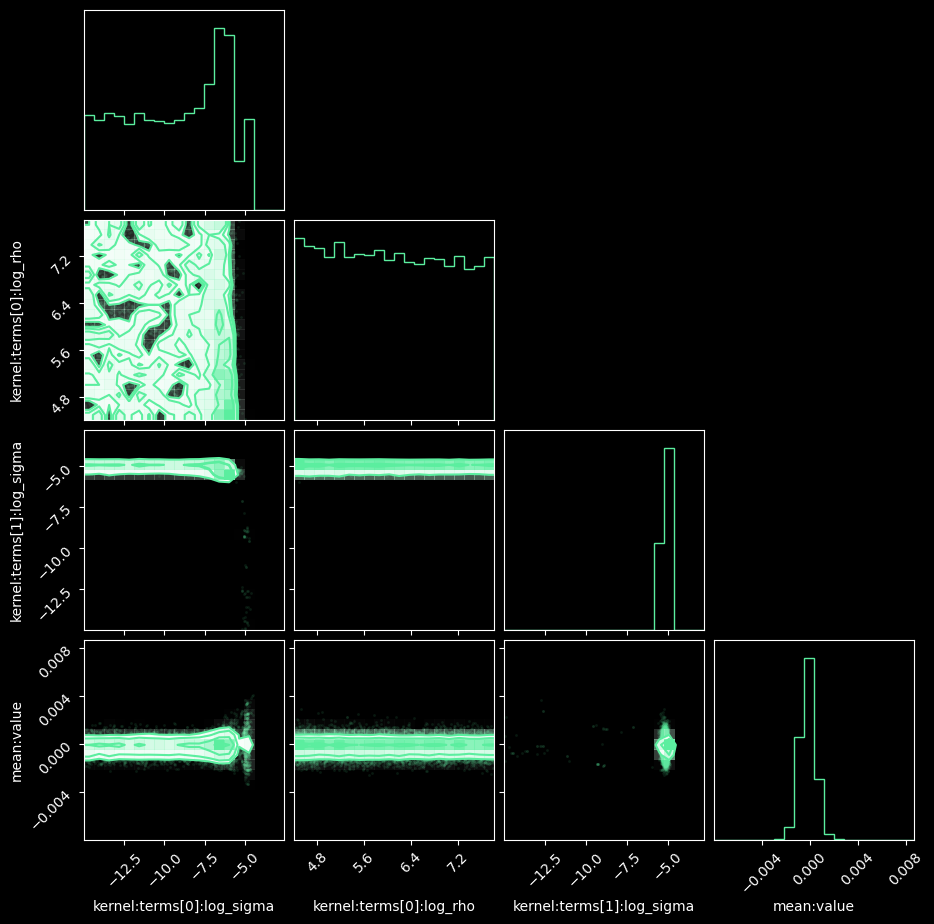

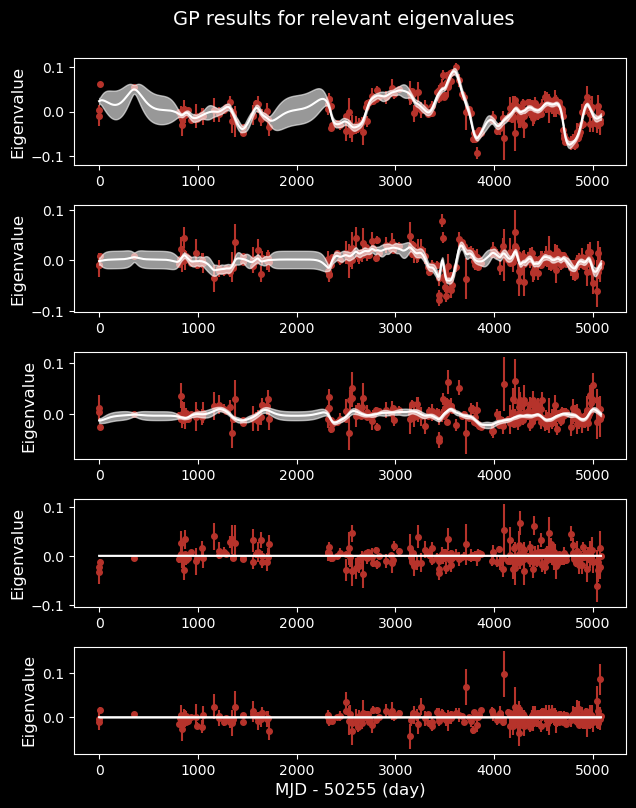

In [9]:
read_old = False
gp_file = os.path.join(data_dir, '{}_gps_fin.npz'.format(psr))
if read_old and os.path.exists(gp_file):
    with np.load(gp_file) as d:
        if exist_DFB and 'DFB_mjds_pred' in d.keys():
            DFB_mjds_pred = d['DFB_mjds_pred']
            DFB_pred_vars = d['DFB_vars_pred']
            DFB_pred_res = d['DFB_res_pred']
        else:
            print("No DFB arrays in npz file")
            
        if exist_AFB and 'AFB_mjds_pred' in d.keys():
            AFB_mjds_pred = d['AFB_mjds_pred']
            AFB_pred_vars = d['AFB_vars_pred']
            AFB_pred_res = d['AFB_res_pred']
        else:
            print("No AFB arrays in npz file")
            
if exist_DFB and 'DFB_pred_res' not in locals():
    print("Running GP for DFB data")
    lags = DFB_mjds[1:] - DFB_mjds[:-1]
    pmin = np.percentile(lags, 97.5)
    print("The minimum length scale for DFB is {:.2f}".format(pmin))
    mjd_range = DFB_mjds[-1] - DFB_mjds[0]
    kern_len = max(pmin*2, mjd_range/10)

    DFB_pred_res, DFB_pred_vars, DFB_mjds_pred = run_each_gp(DFB_eigval, DFB_mjds, DFB_errs, kern_len=kern_len, max_num=3, prior_min=pmin, prior_max=0.5*mjd_range,
                                                             burn_chain=300, prod_chain=5000, num_walkers=200, # these values can be adjusted but should work
                                                             plot_chains=True, plot_corner=True, plot_gps=True, mcmc=True, multi=True,
                                                             verb=True, bk_bgd=use_bk_bgd, gp_plotname=os.path.join(plots_dir, psr+'_dfb_{}_gp_preds.png'.format(freq)))

os.remove('gp_init_threads.py')
if exist_AFB and 'AFB_pred_res' not in locals():
    print("Running GP for AFB data")
    a_lags = AFB_mjds[1:] - AFB_mjds[:-1]
    a_pmin = np.percentile(a_lags, 97.5)
    print("The minimum length scale for AFB is {:.2f}".format(a_pmin))
    a_mjd_range = AFB_mjds[-1] - AFB_mjds[0]
    a_kern_len = max(a_pmin*2, a_mjd_range/10)

    AFB_pred_res, AFB_pred_vars, AFB_mjds_pred = run_each_gp(AFB_eigval, AFB_mjds, AFB_errs, kern_len=a_kern_len, max_num=4, prior_min=a_pmin, prior_max=0.5*a_mjd_range,
                                                             burn_chain=300, prod_chain=5000, num_walkers=200, # these values can be adjusted but should work
                                                             plot_chains=True, plot_corner=True, plot_gps=True, mcmc=True, multi=True,
                                                             verb=True, bk_bgd=use_bk_bgd, gp_plotname=os.path.join(plots_dir, psr+'_afb_{}_gp_preds.png'.format(freq)))


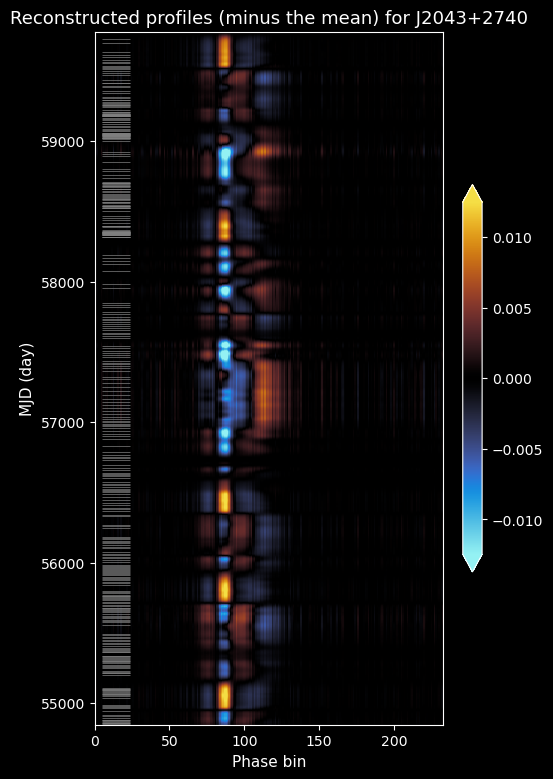

In [10]:
if exist_DFB:
    plot_recon_profs(DFB_mean, DFB_eigvec, DFB_mjds_pred, DFB_pred_res, psr, mjds_real=DFB_mjds, bk_bgd=use_bk_bgd,
                     sub_mean=True, savename=os.path.join(plots_dir, psr+'_dfb_recon_wfall.png'))
    

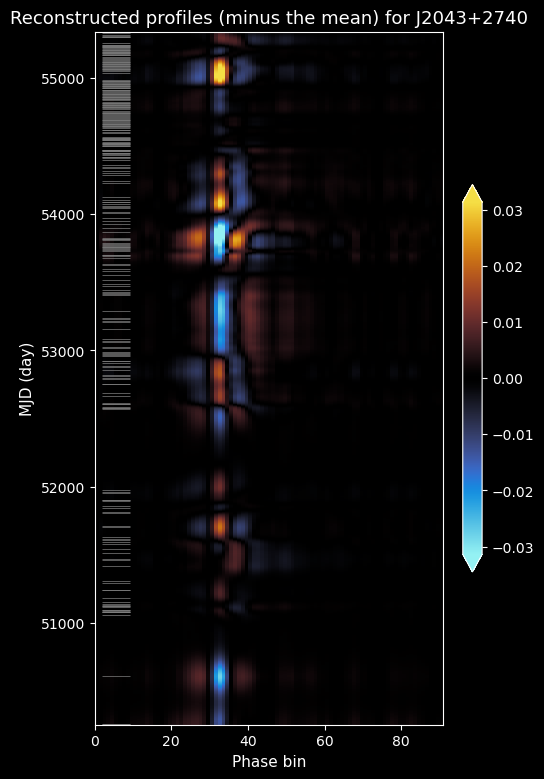

In [11]:
if exist_AFB:
    plot_recon_profs(AFB_mean, AFB_eigvec, AFB_mjds_pred, AFB_pred_res, psr, mjds_real=AFB_mjds, bk_bgd=use_bk_bgd,
                     sub_mean=True, savename=os.path.join(plots_dir, psr+'_afb_recon_wfall.png'))
    

In [12]:
var_dict = {}
if exist_DFB:
    var_dict['DFB_mjds_pred'] = DFB_mjds_pred
    var_dict['DFB_res_pred'] = DFB_pred_res
    var_dict['DFB_vars_pred'] = DFB_pred_vars
    
if exist_AFB:
    var_dict['AFB_mjds_pred'] = AFB_mjds_pred
    var_dict['AFB_res_pred'] = AFB_pred_res
    var_dict['AFB_vars_pred'] = AFB_pred_vars
    
out_file = os.path.join(data_dir, '{}_gps_fin.npz'.format(psr))
np.savez(out_file, **var_dict)
